## One Site QITE
This notebook is a guide to implement QITE on one site

We define a measurement function **measure** and a propagation function **propagate**

In **measure** we define circuits to measure the expectation value of any Pauli string

In **propagate**, we loop through the different values store in alist to construct the states. alist is stored as a list of lists and the indices are a[timestep][gate]. The indices of gate are as follows: 
<br>
<br>
1 stores a[x]: $e^{-ia[x]\Delta\tau\hat{X}}$
<br>
2 stores a[y]: $e^{-ia[y]\Delta\tau\hat{Y}}$
<br>
3 stores a[z]: $e^{-ia[z]\Delta\tau\hat{Z}}$
<br>
<br>
The 0 index stores the coefficient for the identity matrix $\hat{I}$, which is a global phase that we can ignore.

In [1]:
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs,correct_bitstring_probs
from pyquil import Program,get_qc

def measure(p,ro,idx,qc,qbits,correction_matrix):
    # Circuit to measure the expectation value of any Pauli string

    if idx == 0:
        return 1
    elif idx == 1:
        qc = get_qc(qc)
        p += H(qbits[0])
        p += MEASURE(qbits[0],ro[0])
        exe = qc.compile(p)
        res = qc.run(exe)
        probs = estimate_bitstring_probs(res)
        probs = correct_bitstring_probs(probs,[correction_matrix])
        return probs[0] - probs[1]
    elif idx == 2:
        qc = get_qc(qc)
        p += RX(np.pi/2,qbits[0])
        p += MEASURE(qbits[0],ro[0])
        exe = qc.compile(p)
        res = qc.run(exe)
        probs = estimate_bitstring_probs(res)
        probs = correct_bitstring_probs(probs,[correction_matrix])
        return probs[0] - probs[1]
    elif idx == 3:
        qc = get_qc(qc)
        p += MEASURE(qbits[0],ro[0])
        exe = qc.compile(p)
        res = qc.run(exe)
        probs = estimate_bitstring_probs(res)
        probs = correct_bitstring_probs(probs,[correction_matrix])
        return probs[0] - probs[1]


def propagate(p,alist,qbits):
    # Circuit to propagate the state
    if len(alist) == 0:
        None
    else:
        for t in range(len(alist)):
            for gate in range(1,4):
                angle = np.real(alist[t][gate])
                if gate == 1:
                    p += RX(angle,qbits[0])
                elif gate == 2:
                    p += RY(angle,qbits[0])
                elif gate == 3:
                    p += RZ(angle,qbits[0])
                else:
                    raise ValueError

We now want to obtain the coefficients a[m] at the current time step and append to alist. To do this, we need to construct the matrix $S_{ij} = \bra{\psi}\sigma_{i}\sigma_{j}\ket{\psi}$ and the vector $b_{i}$. Well, our earlier functions allow us to measure the expectation values of the different pauli matrices. How do we obtain $S_{ij}$ from a list of $\bra{\psi}\sigma\ket{\psi}$? We can exploit the fact that up to some coefficients, $\sigma_{i}\sigma_{j} = c_{ij}\sigma_{ij}$. For example, $\sigma_{x}\sigma_{y} = i\sigma_{z}$. We will need a matrix to keep track of what pauli matrix and coefficient we get for $\sigma_{i}\sigma_{j}$. These are stored in the matrices **idx** and **coeff** below.


In [2]:
import numpy as np

# To keep track of Lie algebra. Let P represent some Pauli operator. We want to know PiPj = cijPij.

idx = np.zeros([4,4],dtype=int)
idx[0,0] = 0
idx[0,1] = 1
idx[0,2] = 2
idx[0,3] = 3
idx[1,0] = 1
idx[1,1] = 0
idx[1,2] = 3
idx[1,3] = 2
idx[2,0] = 2
idx[2,1] = 3
idx[2,2] = 0
idx[2,3] = 1
idx[3,0] = 3
idx[3,1] = 2
idx[3,2] = 1
idx[3,3] = 0

coeff = np.zeros([4,4],dtype=complex)
coeff[0,0] = 1
coeff[0,1] = 1
coeff[0,2] = 1
coeff[0,3] = 1
coeff[1,0] = 1
coeff[1,1] = 1
coeff[1,2] = 1j
coeff[1,3] = -1j
coeff[2,0] = 1
coeff[2,1] = -1j
coeff[2,2] = 1
coeff[2,3] = 1j
coeff[3,0] = 1
coeff[3,1] = 1j
coeff[3,2] = -1j
coeff[3,3] = 1

print(idx)
print(coeff)

[[0 1 2 3]
 [1 0 3 2]
 [2 3 0 1]
 [3 2 1 0]]
[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  0.+1.j -0.-1.j]
 [ 1.+0.j -0.-1.j  1.+0.j  0.+1.j]
 [ 1.+0.j  0.+1.j -0.-1.j  1.+0.j]]


Using this, we can construct the S matrix and b vector. We use the **idx** and **coeff** matrices and the function np.linalg.std to solve for x in **update_alist**. Because the rotation gate is defined as $e^{-i\theta/2\sigma}$, we multiply the x by 2 before storing them in alist.

In [3]:
def update_alist(sigma_expectation,alist,db,delta,hm):
    # Obtain A[m]

    # Step 1: Obtain S matrix
    S = np.zeros([4,4],dtype=complex)
    for i in range(4):
        for j in range(4):
            S[i,j] = sigma_expectation[idx[i,j]]*coeff[i,j]

    # Step 2: Obtain b vector
    b = np.zeros([4],dtype=complex)
    c = 1
    for i in range(len(hm[0][0])):
        c -= 2*db*hm[0][1][i]*sigma_expectation[hm[0][0][i]]
    c = np.sqrt(c)
    for i in range(4):
        b[i] += (sigma_expectation[i]/c-sigma_expectation[i])/(db)
        for j in range(len(hm[0][0])):
            b[i] -= hm[0][1][j]*coeff[i,hm[0][0][j]]*sigma_expectation[idx[i,hm[0][0][j]]]/c 
        b[i] = 1j*b[i] - 1j*np.conj(b[i])

    # Step 3: Add regularizer
    dalpha = np.eye(4)*delta

    # Step 4: Solve for linear equation, the solution is multiplied by -2 because of the definition of unitary rotation gates is exp(-i theta/2)
    x = np.linalg.lstsq(S+np.transpose(S)+dalpha,-b,rcond=-1)[0]
    alist.append([])
    for i in range(len(x)):
        alist[-1].append(-x[i]*2*db)
    return c

def estimate_assignment_probs(q, shots, qc_name,p00=None,p11=None):
    """
    Estimate the readout assignment probabilities for a given qubit ``q``.
    The returned matrix is of the form::
            [[p00 p01]
             [p10 p11]]
    :param int q: The index of the qubit.
    :param int trials: The number of samples for each state preparation.
    :param qc: The quantum computer we wish to sample.
    :return: The assignment probability matrix
    :rtype: np.array
    """
    qc = get_qc(qc_name)
    if p00 is None:
        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        p += I(q)
        p += MEASURE(q,ro[0])
        exe = qc.compile(p)
        results_i = np.sum(qc.run(exe))

        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        p += X(q)
        p += MEASURE(q,ro[0])
        exe = qc.compile(p)
        results_x = np.sum(qc.run(exe))
    else:
        p = Program()
        p.define_noisy_readout(q,p00=p00,p11=p11)
        ro = p.declare('ro','BIT',1)
        p += I(q)
        p += MEASURE(q,ro[0])
        cxn = QVMConnection()
        results_i = np.sum(cxn.run(p,[0],trials=shots))

        p = Program()
        p.define_noisy_readout(q,p00=p00,p11=p11)
        ro = p.declare('ro','BIT',1)
        p += X(q)
        p += MEASURE(q,ro[0])
        cxn = QVMConnection()
        results_x = np.sum(cxn.run(p,[0],trials=shots))


    p00 = 1. - results_i / float(shots)
    p11 = results_x / float(shots)
    return np.array([[p00, 1 - p11], [1 - p00, p11]])

Now we implement the full QITE protocol. It will be good to have a big picture of what should be done. We step through imaginary time and at each time step, we should first measure the expectation values of the pauli matrices $\sigma$. This is indicated in the first two lines of the for loop. Using the relevant expectation values, we obtain the coefficients $a[m]$ in equation (2.5) of Lecture 12 using the update rule in equation (2.9-2.11). We store it in a list and use this to propagate our state. Note we have to always reconstruct our state for each new measurements we make. Finally, we measure the current energy values. Let us construct the required functions starting with **get_expectation**. We make use of the **measure** function we constructed earlier. The key here is to propagate our state using the coefficients in alist. We do this using the **propagate** function.

In [4]:
import matplotlib.pyplot as plt
# from pyquil.gates import *
# from pyquil.noise import estimate_bitstring_probs
# from pyquil import Program,get_qc

def ansatz(p,qbits):
    None

def measure_energy(alist,shots,qc,qbits,hm_list,correction_matrix):
    # Measure the energy at the end of each time step
    Energy = 0
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        for hm in hm_list[i]:
            for j in range(len(hm[0])):
                p = Program()
                p.wrap_in_numshots_loop(shots)
                # declare readout register with 1 bit
                ro = p.declare('ro','BIT',1)
                ansatz(p,qbits)
                propagate(p,alist,qbits)
                Energy += hm[1][j]*measure(p,ro,hm[0][j],qc,qbits,correction_matrix)
    return Energy

def get_expectation(alist,shots,qc,qbits,correction_matrix):
    # Obtain the expectation values of the Pauli string at each time step

    sigma_expectation = np.zeros([4],dtype=complex)
    for j in range(4):
        p = Program()
        p.wrap_in_numshots_loop(shots)
        ro = p.declare('ro','BIT',1)
        ansatz(p,qbits)
        propagate(p,alist,qbits)
        sigma_expectation[j] = measure(p,ro,j,qc,qbits,correction_matrix)
    return sigma_expectation

def qite_step(alist,shots,qc,qbits,correction_matrix,db,delta,hm_list):
    for j in range(len(hm_list)):
        sigma_expectation = get_expectation(alist,shots,qc,qbits,correction_matrix)
        norm = update_alist(sigma_expectation,alist,db,delta,hm_list[j])
#         print("sigma expectation: ", sigma_expectation)
#         print("norm: ", norm)
    return alist

def qite(qc,qbits,shots,db,delta,N,hm_list):
    E = np.zeros([N+1],dtype=complex)
    alist = []

    # Readout error mitigation, estimate p(0|0),p(0|1),p(1|0),p(1|1)
    correction_matrix = estimate_assignment_probs(qbits[0],20000,qc)
    E[0] = measure_energy(alist,shots,qc,qbits,hm_list,correction_matrix)
    print("Initial energy: ", E[0])
    # Qite main loop
    for i in range(1,N+1):
        correction_matrix = estimate_assignment_probs(qbits[0],20000,qc)
        alist = qite_step(alist,shots,qc,qbits,correction_matrix,db,delta,hm_list)
        E[i] = measure_energy(alist,shots,qc,qbits,hm_list,correction_matrix)
#         print("a list: ", alist)
        print("energy: ", E[i])
    return E

In [5]:
# ---- input parameters for qite
# Produces Figure 2(e) of https://arxiv.org/pdf/1901.07653.pdf
N = 25
shots = 1000
db = 0.1
qc = '1q-qvm'
qbits = [0]
# construct hm_list to represent the 1-qubit Hamiltonian H = 1/sqrt(2) (X + Z)
hm_list = []
hm_list.append([])
# the X part of H
hm_list[0].append([[1],[1/np.sqrt(2)]])
hm_list.append([])
# the Z part of H
hm_list[1].append([[3],[1/np.sqrt(2)]])
print("hm list: ", hm_list)
delta = 0.1
print("running qite...")
E = qite(qc,qbits,shots,db,delta,N,hm_list)

hm list:  [[[[1], [0.7071067811865475]]], [[[3], [0.7071067811865475]]]]
running qite...
Initial energy:  (0.6745798692519662+0j)
energy:  (0.6052834046956848+0j)
energy:  (0.4058792924010781+0j)
energy:  (0.2927422074112306+0j)
energy:  (0.057982756057296914+0j)
energy:  (-0.12869343417595153+0j)
energy:  (-0.3196122650963194+0j)
energy:  (-0.5275016587651644+0j)
energy:  (-0.609526045382804+0j)
energy:  (-0.7184204896855322+0j)
energy:  (-0.8315575746753797+0j)
energy:  (-0.878226622233692+0j)
energy:  (-0.9291383104791233+0j)
energy:  (-0.9164103884177657+0j)
energy:  (-0.9277240969167503+0j)
energy:  (-0.9687362902255701+0j)
energy:  (-0.9913637072235396+0j)
energy:  (-0.9390378054157351+0j)
energy:  (-0.9786357851621819+0j)
energy:  (-0.9786357851621817+0j)
energy:  (-0.9885352800987933+0j)
energy:  (-0.9588367952889583+0j)
energy:  (-1.0040916292848974+0j)
energy:  (-0.982878425849301+0j)
energy:  (-1.013991124221509+0j)
energy:  (-0.9927779207859125+0j)


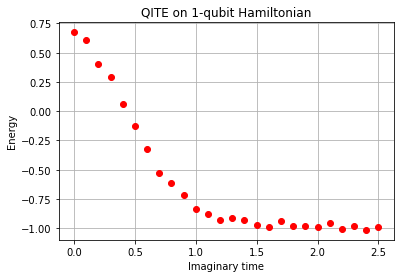

In [6]:
# some trouble with numpy sometimes because of imaginary part... so plot only real part of E
plt.plot(np.arange(0,N+1)*db,E.real,'ro',label='QITE')
plt.title("QITE on 1-qubit Hamiltonian")
plt.xlabel("Imaginary time")
plt.ylabel("Energy")
plt.grid()
plt.show()